In [1]:
# !pip install fastjet

In [1]:
import glob
import os
import sys

sys.path.insert(0, "hbb_interaction_network")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

In [2]:
# define the global base device
world_size = torch.cuda.device_count()
multi_gpu = world_size >= 2
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")

Device 0: NVIDIA A100 80GB PCIe MIG 1g.10gb


In [4]:
! ls /../ssl-jet-vol-v2/toptagging/*/processed

/../ssl-jet-vol-v2/toptagging/test/processed:
data_0.pt  data_1.pt  data_2.pt  data_3.pt  data_quick.pt

/../ssl-jet-vol-v2/toptagging/train/processed:
data_0.pt   data_11.pt	data_2.pt  data_4.pt  data_6.pt  data_8.pt
data_10.pt  data_1.pt	data_3.pt  data_5.pt  data_7.pt  data_9.pt

/../ssl-jet-vol-v2/toptagging/val/processed:
data_0.pt  data_1.pt  data_2.pt  data_3.pt


In [3]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files!=-1 and i==n_files-1:
            break
                
    return data

dataset_path = "/../ssl-jet-vol-v2/toptagging/"

data_train = load_data(dataset_path, "train", n_files=1)
# data_valid = load_data(dataset_path, "val", n_files=4)
# data_test = load_data(dataset_path, "val", n_files=1)

--- loaded file 0 from `train` directory


In [6]:
len(data_test)

100001

In [7]:
data_train[:4]

[Data(x=[23, 7], y=0),
 Data(x=[43, 7], y=0),
 Data(x=[41, 7], y=0),
 Data(x=[25, 7], y=0)]

In [4]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [5]:
num_features = 7

In [6]:
batch_size = 100

train_loader = DataLoader(data_train, batch_size)
# valid_loader = DataLoader(data_valid, batch_size)
# test_loader = DataLoader(data_test, batch_size)

In [7]:
train_loader

### see the range of ptp_eta

In [12]:
ptp_eta_lst = []
for i, bb in enumerate(test_loader):
    bb = bb.clone()
    bb = bb.to("cpu")
    X = bb.x.numpy()
    ptp_eta = np.ptp(X[:,0], axis=-1, keepdims=True)
    ptp_eta_lst.append(ptp_eta[0])
#     print(f"ptp_eta for batch {i} : {ptp_eta}")
#     if i == 30:
#         break
    

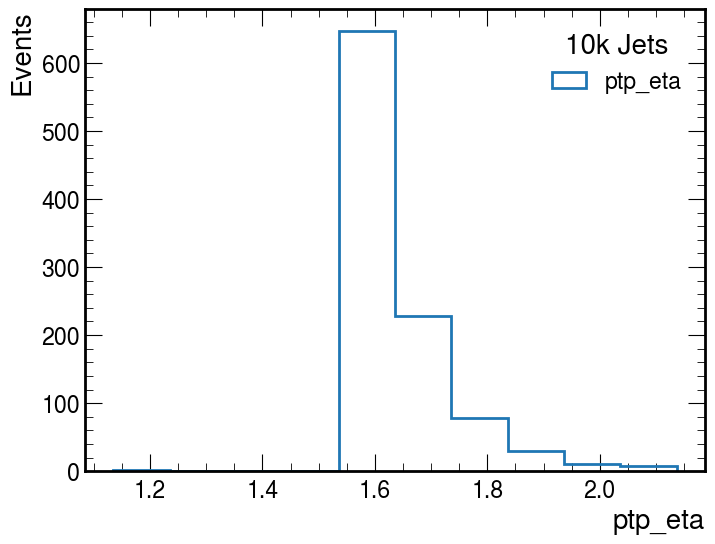

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(ptp_eta_lst, bins=10, histtype="step", linewidth=2, label=f"ptp_eta")

ax.legend(title="10k Jets")
ax.set_xlabel(r"ptp_eta");
ax.set_ylabel(r"Events");

In [14]:
for i, bb in enumerate(train_loader):
    break

# Translate Jets

In [23]:
def translate_jets(batch, width=1.0, device='cpu'):
    width = 1.0
    bb = batch.clone()
    bb = bb.to("cpu")
    X = bb.x.numpy()
    ptp_eta = np.ptp(X[:,0], axis=-1, keepdims=True)
    ptp_phi = np.ptp(X[:,1], axis=-1, keepdims=True)
    low_eta  = -width*ptp_eta
    print(f"low eta: {low_eta}")
    high_eta = +width*ptp_eta
    print(f"high eta: {high_eta}")
    low_phi = np.maximum(-width*ptp_phi, -np.pi-np.min(X[:,1]).reshape(ptp_phi.shape))
    print(f"low phi: {low_phi}")
    high_phi = np.minimum(+width*ptp_phi, +np.pi-np.max(X[:,1]).reshape(ptp_phi.shape))
    print(f"high phi: {high_phi}")
    shift_eta_batch = np.random.uniform(low=low_eta, high=high_eta, size=(bb.y.shape[0], 1))  
    shift_phi_batch = np.random.uniform(low=low_phi, high=high_phi, size=(bb.y.shape[0], 1))  
    
    # To make sure that the components of each jet get shifted by the same amount
    for i in range(len(bb)):
        X_jet = bb[i].x.numpy()
        shift_eta_jet = np.ones((X_jet.shape[0], 1)) * shift_eta_batch[i]
        shift_phi_jet = np.ones((X_jet.shape[0], 1)) * shift_phi_batch[i]
        if i == 0:
            shift_eta = shift_eta_jet
            shift_phi = shift_phi_jet
        else:
            shift_eta = np.concatenate((shift_eta, shift_eta_jet))
            shift_phi = np.concatenate((shift_phi, shift_phi_jet))

    shift = np.hstack((shift_eta, shift_phi, np.zeros((X.shape[0], 5))))
    new_X = X + shift
    new_X = torch.tensor(new_X).to(device)
    bb.x = new_X
    return bb.to(device)

## Test translate_jets()

In [24]:
new_batch = translate_jets(bb, device=device)

low eta: [-1.5893445]
high eta: [1.5893445]
low phi: [-1.5909317]
high phi: [1.5909317]


In [25]:
bb[0].x[:, 0]

tensor([ 0.0048, -0.0304,  0.0032, -0.0078,  0.0176, -0.0078, -0.0123, -0.0224,
        -0.0214,  0.0220, -0.0722,  0.0343,  0.0810,  0.0298, -0.0354,  0.0295,
         0.0528,  0.1544,  0.0066, -0.2777, -0.2948,  0.4583, -0.0605])

In [26]:
new_batch[0].x[:, 0]
# new_batch.x.device

tensor([1.0788, 1.0436, 1.0772, 1.0662, 1.0916, 1.0662, 1.0617, 1.0516, 1.0526,
        1.0960, 1.0018, 1.1083, 1.1550, 1.1038, 1.0386, 1.1035, 1.1268, 1.2283,
        1.0806, 0.7963, 0.7792, 1.5322, 1.0135], device='cuda:0',
       dtype=torch.float64)

In [27]:
i=0
new_batch.cpu()[i].x[:, 0].numpy() - bb.cpu()[i].x[:, 0].numpy()

array([1.07397973, 1.07397973, 1.07397973, 1.07397973, 1.07397973,
       1.07397973, 1.07397973, 1.07397973, 1.07397973, 1.07397973,
       1.07397973, 1.07397973, 1.07397973, 1.07397973, 1.07397973,
       1.07397973, 1.07397973, 1.07397973, 1.07397973, 1.07397973,
       1.07397973, 1.07397973, 1.07397973])

# Rotate Jets

In [66]:
def rotate_jets(batch, device):
    bb = batch.clone()
    bb = bb.to("cpu")
    rot_angle = np.random.rand(len(bb))*2*np.pi
#     print(rot_angle)
    c = np.cos(rot_angle)
    s = np.sin(rot_angle)
    o = np.ones_like(rot_angle)
    z = np.zeros_like(rot_angle)
    rot_matrix = np.array([[z, c, -s], [z, s, c], [o, z, z]])  # (3, 3, 100)
    rot_matrix = rot_matrix.transpose(2,0,1)  # (100, 3, 3)

    for i in range(len(bb)):
        x_ = bb[i].x[:,:3]
        new_x = np.einsum('ij,jk', bb[i].x[:,:3], rot_matrix_tr[i])  # this is somehow (pT, eta', phi')
        new_x[:, [0,2]] = new_x[:, [2, 0]] 
        new_x[:, [0,1]] = new_x[:, [1, 0]] # now (phi', eta', pT)
        
        if i == 0:
            new_X = new_x
        else:
            new_X = np.concatenate((new_X, new_x), axis=0)

    new_X = torch.tensor(new_X).to(device)
    bb.x = new_X
    return bb.to(device)

## Test rotate_jets()

In [10]:
for i, batch in enumerate(train_loader):
    if i == 1:
        break

In [67]:
new_batch = rotate_jets(batch, device=device)

In [68]:
new_batch[0].x[:,:3]

tensor([[-6.0437e-02, -2.9798e-02,  4.9351e+00],
        [ 1.1935e-01,  2.6293e-01,  4.5134e+00],
        [ 1.1935e-01,  2.6293e-01,  3.8842e+00],
        [ 2.2080e-02, -5.8930e-02,  3.7488e+00],
        [ 1.6222e-02, -6.6628e-02,  3.5040e+00],
        [-2.5196e-01, -5.0939e-01,  3.3562e+00],
        [ 1.2240e-01,  2.5398e-01,  2.9413e+00],
        [ 4.7167e-02, -3.4889e-02,  2.6665e+00],
        [ 1.5118e-01,  2.6092e-01,  2.5321e+00],
        [-3.0791e-01, -5.3602e-01,  2.2583e+00],
        [ 8.9111e-02, -8.4846e-02,  2.1801e+00],
        [ 1.0256e-01,  2.9138e-01,  2.1715e+00],
        [ 1.9424e-01,  2.4204e-01,  2.0848e+00],
        [-2.2788e-01, -5.0678e-01,  1.7994e+00],
        [-2.4578e-01, -4.4921e-01,  1.6775e+00],
        [-7.9526e-04,  2.4844e-01,  1.6761e+00],
        [-1.8728e-02, -6.2828e-02,  1.6329e+00],
        [-2.5419e-01, -4.2511e-01,  1.6205e+00],
        [ 1.0769e-01,  2.2927e-01,  1.5918e+00],
        [-4.4587e-01, -4.5636e-01,  1.5623e+00],
        [-4.4538e-02

# Other augmentations

In [11]:
def rescale_pts(batch):
    x_rscl = batch.x.clone()
    batch.x[:,2] = torch.nan_to_num(x_rscl[:,2]/600, posinf=0.0, neginf=0.0)
    return batch

In [12]:
def normalize_pts( batch ):
    x_norm = batch.x.clone()
    batch.x[:,2] = torch.nan_to_num(x_norm[:,2]/torch.sum(x_norm[:,2]), posinf = 0.0, neginf = 0.0 )
    return batch

In [13]:
# 0,1,2, eta, phi, pT

# Training VICReg with ParticleNet

In [14]:
from typing import Callable, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor
from pdb import set_trace as bp

class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        k=16,
        depth=2,
        dropout=False,
        device = "cpu"
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = k
        self.num_edge_conv_blocks = 3
        
        self.augmentations = True

        self.kernel_sizes = [self.node_feat_size, 64, 128, 256]
        self.input_sizes = np.cumsum(self.kernel_sizes)  # [4, 4+64, 4+64+128, 4+64+128+256]

        self.fc_size = 256
        self.device = device

        if dropout:
            self.dropout = 0.1
            self.dropout_layer = nn.Dropout(p=self.dropout)
        else:
            self.dropout = None

        # define the edgeconvblocks
        self.edge_conv_blocks = nn.ModuleList()
        for i in range(0, self.num_edge_conv_blocks):
            self.edge_conv_blocks.append(EdgeConvBlock(self.input_sizes[i], self.kernel_sizes[i + 1], depth=depth))

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(self.input_sizes[-1], self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()
    
#     def augmentations(self, batch):
#         batch = rescale_pts(batch)
#         batch = rotate_jets(batch, self.device)
#         batch = translate_jets(batch, device = self.device)
#         batch = normalize_pts(batch)
    

    def forward(self, batch):
        if self.augmentations:
            batch = rescale_pts(batch)
            batch = rotate_jets(batch, self.device)
            batch = translate_jets(batch, device = self.device)
            batch = normalize_pts(batch)
        
        x = batch.x
        y = batch.y
        batch = batch.batch

        # input transformations
#         x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
#         x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
#         x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
#         x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
#         x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        edge_index = {}
        for i in range(self.num_edge_conv_blocks):
            # using only angular coords for knn in first edgeconv block
            edge_index[f"edge_conv_{i}"] = knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)

            out = self.edge_conv_blocks[i](x, edge_index[f"edge_conv_{i}"])

            x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.fc2(x)
        x = self.sig(x)

        return x, y

In [15]:
# setup the input/output dimension of the model
num_features = 7  # we have 7 input features
num_classes = 1  # we have one output node

In [16]:
model_kwargs = {
    "node_feat_size": num_features,
    "num_classes": num_classes,
    "k": 16,
    "depth": 3,
    "dropout": True,
    "device":device
}

model = ParticleNet(**model_kwargs)
model.to(device)

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [18]:
# quick training without monitoring validation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()

for epoch in tqdm(range(10)):
    losses = []
    for i, batch in tqdm(enumerate(train_loader)):
        preds, targets = model(batch.to(device))
        loss = criterion(sig(preds), targets.reshape(-1, 1).float())
#         print(f"batch # {i}, loss={loss:.3f}")

        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())

    losses = sum(losses)/len(losses)
    print(f"epoch {epoch}, loss: {losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

epoch 0, loss: 0.573233962059021


0it [00:00, ?it/s]

epoch 1, loss: 0.5649367570877075


0it [00:00, ?it/s]

epoch 2, loss: 0.5618266463279724


0it [00:00, ?it/s]

epoch 3, loss: 0.5604450106620789


0it [00:00, ?it/s]

epoch 4, loss: 0.5591593980789185


0it [00:00, ?it/s]

epoch 5, loss: 0.5580376386642456


0it [00:00, ?it/s]

epoch 6, loss: 0.5573257803916931


0it [00:00, ?it/s]

epoch 7, loss: 0.5568434596061707


0it [00:00, ?it/s]

epoch 8, loss: 0.5564178228378296


0it [00:00, ?it/s]

epoch 9, loss: 0.5559555292129517


In [19]:
# model.eval()
# with torch.no_grad():
#     for i, batch in tqdm(enumerate(val_loader)):
#         preds, targets = model(batch.to(device))
#         loss = criterion(sig(preds), targets.reshape(-1, 1).float())
#         val_losses.append(loss.item())
        
# val_loss = sum(val_losses) / len(val_losses)
# print("Val loss : {}".format(val_loss))

In [20]:
def make_roc(y_test, y_score, save_path = 'roc', save_flag=False):
    fpr, tpr, _ = roc_curve(y_test, y_score)

    fig, ax = plt.subplots(figsize=(8,7))
    ax.plot(
        tpr,
        fpr,
        color="darkorange",
        lw=2,
        label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
    )
    plt.xlim([0.0, 1.0])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.yscale("log")
    plt.legend(loc="lower right")
    if save_flag:
        plt.savefig(f'toptagging_expts/plots/{save_path}.jpg')
    

In [21]:
print("- making predictions")
y_score = None
y_test = None

model.eval()
model.augmentations = False
for i, batch in tqdm(enumerate(test_loader)):

    preds, targets = model(batch.to(device))
    preds = preds.detach().cpu()

    if y_score is None:
        y_score = preds[:].detach().cpu().reshape(-1)
        y_test = targets.detach().cpu()
    else:
        y_score = torch.cat([y_score, preds[:].detach().cpu().reshape(-1)])
        y_test = torch.cat([y_test, targets.detach().cpu()])

#     if i==100:
#         break

- making predictions


0it [00:00, ?it/s]

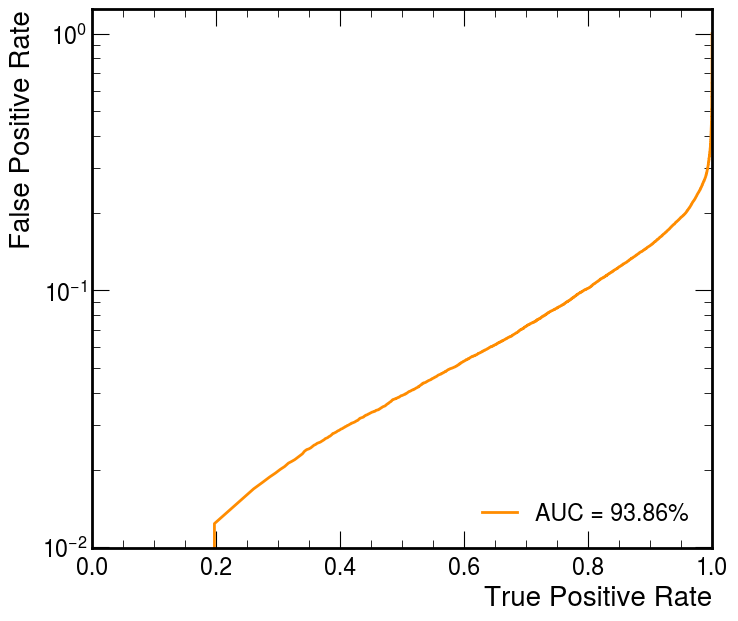

In [22]:
plt.rcParams.update({"font.size": 20})
make_roc(y_test, y_score, 'roc_rescl_rotate_transl_norm',save_flag=False)